In [1]:
#Import relevant libraries
import astropy
import numpy as np
import ccdproc
import os
import glob
import matplotlib.pyplot as plt
from astropy.nddata import CCDData
from astropy.table import Table
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from matplotlib import markers
import scipy

In [2]:
#This document is the most important document outlining our isochrone fit on our final CMD of M15
#Here we read in our B and V science images

B = astropy.nddata.CCDData.read('C:/Users/steve/OneDrive - University of Birmingham/LH Observatory Laboratory/Glob Cluter Final Code/GlobClusters/MasterScienceB.fits', unit='adu')

V = astropy.nddata.CCDData.read('C:/Users/steve/OneDrive - University of Birmingham/LH Observatory Laboratory/Glob Cluter Final Code/GlobClusters/MasterScienceVshift.fits', unit='adu')


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [3]:
#We once again obtain our background median and rms median values are they are essential for this section for both B and V

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkgB = Background2D(B, (128, 128), filter_size=(5,5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

print(bkgB.background_median)  
print(bkgB.background_rms_median)  

bkgB_median = bkgB.background_median.value
bkgB_rms = bkgB.background_rms.value
bkgB_rms_median = bkgB.background_rms_median.value

192.2201797890617 adu
6.328260030000077 adu


In [4]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkgV = Background2D(V, (128, 128), filter_size=(5,5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

print(bkgV.background_median)  
print(bkgV.background_rms_median)  

bkgV_median = bkgV.background_median.value
bkgV_rms = bkgV.background_rms.value
bkgV_rms_median = bkgV.background_rms_median.value

322.22940265817033 adu
3.315165808663122 adu


In [5]:
#Here we produce a table of all the sources in the B band
tblB = Table.read('table_B', format='ascii')
#tblB.show_in_notebook()

In [6]:
#Here we produce a table of all the sources in the V band
tblV = Table.read('table_V', format='ascii')
#tblV.show_in_notebook()

In [7]:
#Some sources have a value of 'naan' which is due to an indifference of their not being a star in the V band that corresponds to the same position in the V band hence we remove them
has_nan = np.zeros(len(tblB), dtype=bool)
for col in tblB.itercols():
    if col.info.dtype.kind == 'f':
        has_nan |= np.isnan(col)
tblB = tblB[~has_nan]

In [8]:
has_nan = np.zeros(len(tblV), dtype=bool)
for col in tblV.itercols():
    if col.info.dtype.kind == 'f':
        has_nan |= np.isnan(col)
tblV = tblV[~has_nan]

In [9]:
#tblV.show_in_notebook()

In [10]:
#tblB.show_in_notebook()

In [11]:
#xdif = (tblV['xcentroid'][24] - tblB['xcentroid'][22])
#ydif = (tblV['ycentroid'][24] - tblB['ycentroid'][22])
#print(xdif, ydif)

In [12]:
#tblB['xcentroid'] = tblB['xcentroid'] + xdif
#tblB['ycentroid'] = tblB['ycentroid'] + ydif

In [13]:
#Here we produce our source positions with a pixel radius of 6 for each source
apV = CircularAperture(np.column_stack((tblV['xcentroid'], tblV['ycentroid'])), 6)
apB = CircularAperture(np.column_stack((tblB['xcentroid'], tblB['ycentroid'])), 6)

In [14]:
#These are the errors on apertume sum for the B and V band
from photutils.utils import calc_total_error

errorV = calc_total_error(V, bkg_error = bkgV_rms, effective_gain = 2.2)
errorB = calc_total_error(B, bkg_error = bkgB_rms, effective_gain = 2.2)

In [15]:
#This table shows the positions of each source within our region and the effective luminosity of the source
aperture_tableV = aperture_photometry(np.array(V - bkgV.background), apB, errorV)
aperture_tableV.show_in_notebook()

idx,id,xcenter,ycenter,aperture_sum,aperture_sum_err
,,pix,pix,,
0,1,2386.99828083146,0.8915182269343264,-31.35148172648159,107.70797766843211
1,2,2820.569419689576,10.816967883637115,14519.94827949821,156.92217273573746
2,3,2786.0523811039498,13.425570497556262,22.907678066962273,134.2803694684089
3,4,3198.0,13.594029167936023,-52.22619893669869,134.35516686407553
4,5,3614.1522360390936,21.557993577779122,-10.681337816458178,134.59410503249893
5,6,2473.010228744451,36.76046845826199,-216.06014819038452,133.69921478721236
6,7,3245.112527078182,44.29219085354827,-73.16174227937422,134.33252590607398
7,8,3856.0157904011967,43.796841163914245,-176.46994002368942,134.593855210725
8,9,911.1075383951126,57.72163080658854,-61.004063977863396,133.12502793030188


In [16]:
#This table does the same as the table above but for the B bad
aperture_tableB = aperture_photometry(np.array(B - bkgB.background), apB, errorB)
#aperture_tableB.show_in_notebook()

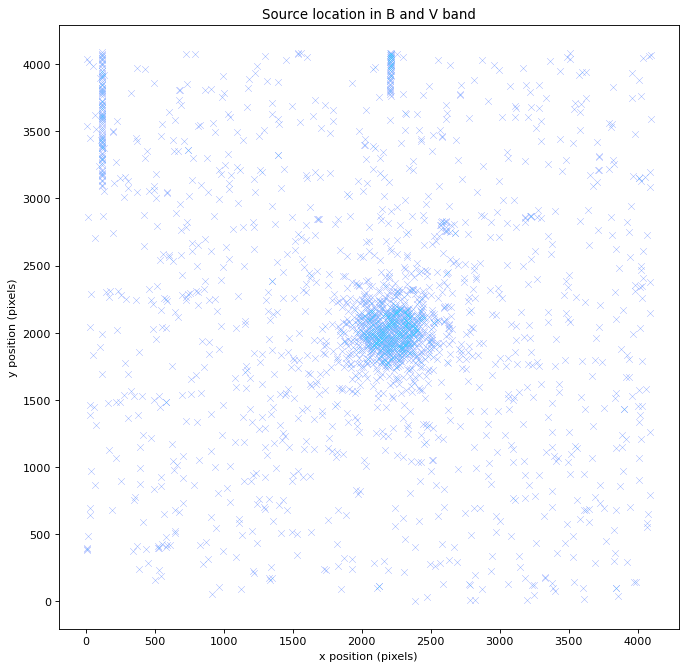

In [17]:
#Here we plot the positions of sources in both bands to see if they align

xB = aperture_tableB['xcenter']
yB = aperture_tableB['ycenter']
xV = aperture_tableV['xcenter']
yV = aperture_tableV['ycenter']

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(xB, yB, marker = 'x', alpha=0.5, color='magenta', linewidths=0.3)
plt.scatter(xV, yV, marker = 'x', alpha=0.5, color='cyan', linewidths=0.3)

plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('Source location in B and V band')
plt.savefig('Source location in B and V band')

plt.show()

In [18]:
#This table presents all the sources in the image which are within a circular annulus with a minimum distance of 50 pixels and max of 200 pixels
#This is for the B band

from astropy import table

starsBx = []
starsBy = []
starsB = []
starsBerr=[]
#6, 125
rmin=50
rmax=200
xcent=2.11926492e+02 + 2000
ycent=1.97100517e+02 + 1800

for i in aperture_tableB:
    if ((i['xcenter'].value - xcent)**2 + (i['ycenter'].value - ycent)**2)**(0.5)>rmin and ((i['xcenter'].value - xcent)**2 + (i['ycenter'].value - ycent)**2)**(0.5)<rmax:
        starsBx.append(i['xcenter'])
        starsBy.append(i['ycenter'])
        starsB.append(i['aperture_sum'])
        starsBerr.append(i['aperture_sum_err'])
        
tableB = Table([starsBx, starsBy, starsB, starsBerr], names=('starsBx', 'starsBy' ,'starsB', 'starsBerr'))
tableB    

starsBx,starsBy,starsB,starsBerr
pix,pix,,
float64,float64,float64,float64
2251.0200493120224,1823.0596252145715,1462.4500007831969,127.34637756162925
2273.748380885574,1833.4808861801519,1658.687306374396,127.5037838607888
2326.222539450367,1836.7408147520284,2371.4263376591994,127.80756347177483
2304.6160421306336,1838.504635140217,1884.8521760246374,127.41162083690371
2259.5791850490336,1838.174841737867,994.4129712031794,126.62969772432582
2119.0360020826997,1840.2327717052383,1117.5067210901555,127.15164989901832
2201.544210426015,1840.495821964357,1102.568162748385,127.49447135560456
2291.427105307131,1852.5465926796617,1512.7305409501428,127.24140796465548


In [19]:
#We do the same as above but for the V band

starsVx = []
starsVy = []
starsV = []
starsVerr=[]

for i in aperture_tableV:
    if ((i['xcenter'].value - xcent)**2 + (i['ycenter'].value - ycent)**2)**(0.5)>rmin and ((i['xcenter'].value - xcent)**2 + (i['ycenter'].value - ycent)**2)**(0.5)<rmax:
        starsVx.append(i['xcenter'])
        starsVy.append(i['ycenter'])
        starsV.append(i['aperture_sum'])
        starsVerr.append(i['aperture_sum_err'])
        
tableV = Table([starsVx, starsVy, starsV, starsVerr], names=('starsVx', 'starsVy' ,'starsV', 'starsVerr'))
tableV    

starsVx,starsVy,starsV,starsVerr
pix,pix,,
float64,float64,float64,float64
2251.0200493120224,1823.0596252145715,2706.7765058200857,146.5428180293545
2273.748380885574,1833.4808861801519,4413.461718885446,149.1543922880079
2326.222539450367,1836.7408147520284,4743.787175829237,148.45218918121068
2304.6160421306336,1838.504635140217,6069.136587821562,151.1288389258682
2259.5791850490336,1838.174841737867,2002.7733634689314,145.95033378430628
2119.0360020826997,1840.2327717052383,3378.7829412241404,148.69952718984374
2201.544210426015,1840.495821964357,2210.0198853468287,147.38609464603545
2291.427105307131,1852.5465926796617,5519.473998122457,151.1824632255172


In [20]:
#Produce a table with all B and V parameters and components 

tableBV = Table([starsBx, starsBy, starsB, starsBerr, starsVx, starsVy, starsV, starsVerr], names=('starsBx', 'starsBy' ,'starsB', 'starsBerr', 'starsVx', 'starsVy' ,'starsV', 'starsVerr'))

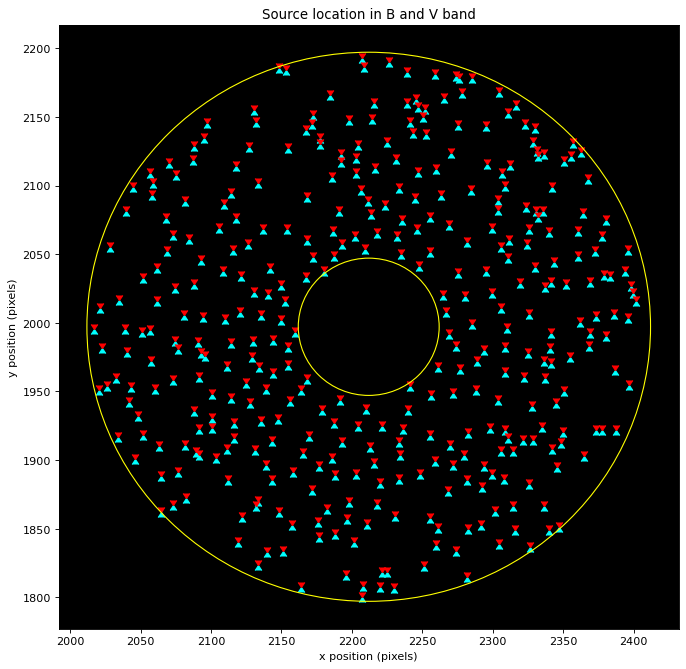

In [21]:
#We not plot an image of the ring of data we are going to look at and each indivudal source in the B and V band
#The red arrow and blue arrow shows that they align

from matplotlib import patches

xB = tableBV['starsBx']
yB = tableBV['starsBy']
xV = tableBV['starsVx']
yV = tableBV['starsVy']

fig = plt.figure(figsize=(10, 10), dpi=80)
ax1 = fig.add_subplot(1, 1, 1)

ax1.set_facecolor('black')
ax1.scatter(xB, yB, marker = 6, alpha=1, color='cyan', linewidths=1)
ax1.scatter(xV, yV, marker = 7, alpha=1, color='red', linewidths=1)
#for i in range(len(xB)):
    #circles = patches.Circle((xB[i], yB[i]), radius=3, fill=False, edgecolor='white', linewidth=1)
    #ax1.add_patch(circles)
annulus1 = patches.Circle((xcent, ycent), radius = rmax, fill=False, edgecolor='yellow', linewidth=1)
annulus2 = patches.Circle((xcent, ycent), radius = rmin, fill=False, edgecolor='yellow', linewidth=1)    
ax1.add_patch(annulus1)
ax1.add_patch(annulus2)

#plt.imshow(B-bkgB.background, vmin=0, vmax=200, cmap='inferno')
#plt.xlim(1700,2500)
#plt.ylim(1700,2400)
plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('Source location in B and V band')
plt.savefig('Source location in B and V band')

plt.show()

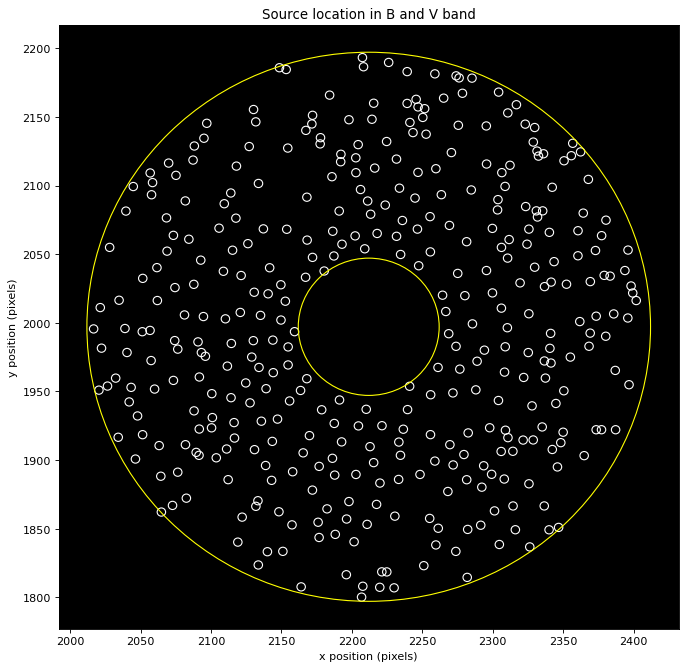

In [22]:
#Here we are interested to see if any sources overlap

xB = tableBV['starsBx']
yB = tableBV['starsBy']
xV = tableBV['starsVx']
yV = tableBV['starsVy']

fig = plt.figure(figsize=(10, 10), dpi=80)
ax1 = fig.add_subplot(1, 1, 1)

ax1.set_facecolor('black')
ax1.scatter(xB, yB, marker = 6, alpha=1, color='black', linewidths=1)
#ax1.scatter(xV, yV, marker = 7, alpha=1, color='red', linewidths=1)
for i in range(len(xB)):
    circles = patches.Circle((xB[i], yB[i]), radius=3, fill=False, edgecolor='white', linewidth=1)
    ax1.add_patch(circles)
    
annulus1 = patches.Circle((xcent, ycent), radius = rmax, fill=False, edgecolor='yellow', linewidth=1)
annulus2 = patches.Circle((xcent, ycent), radius = rmin, fill=False, edgecolor='yellow', linewidth=1)    
ax1.add_patch(annulus1)
ax1.add_patch(annulus2)

#plt.imshow(B-bkgB.background, vmin=0, vmax=200, cmap='inferno')
#plt.xlim(1700,2500)
#plt.ylim(1700,2400)
plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('Source location in B and V band')
plt.savefig('Source location in B and V band')

plt.show()

In [23]:
#We now apply our SNR of 3 to all the sources in the B and V band and produce a table labelling all of them together

starsBx1 = []
starsBy1 = []
starsB1 = []
starsBerr1=[]
starsVx1 = []
starsVy1 = []
starsV1 = []
starsVerr1=[]
SNR = 3

for i in tableBV:
    if (i['starsB'] > SNR*i['starsBerr']):
        starsBx1.append(i['starsBx'])
        starsBy1.append(i['starsBy'])
        starsB1.append(i['starsB'])
        starsBerr1.append(i['starsBerr'])
        starsVx1.append(i['starsVx'])
        starsVy1.append(i['starsVy'])
        starsV1.append(i['starsV'])
        starsVerr1.append(i['starsVerr'])
        
tableB1 = Table([starsBx1, starsBy1, starsB1, starsBerr1], names=('starsBx1', 'starsBy1' ,'starsB1', 'starsBerr1'))
tableB1    

starsBx1,starsBy1,starsB1,starsBerr1
float64,float64,float64,float64
2251.0200493120224,1823.0596252145715,1462.4500007831969,127.34637756162925
2273.748380885574,1833.4808861801519,1658.687306374396,127.5037838607888
2326.222539450367,1836.7408147520284,2371.4263376591994,127.80756347177483
2304.6160421306336,1838.504635140217,1884.8521760246374,127.41162083690371
2259.5791850490336,1838.174841737867,994.4129712031794,126.62969772432582
2119.0360020826997,1840.2327717052383,1117.5067210901555,127.15164989901832
2201.544210426015,1840.495821964357,1102.568162748385,127.49447135560456
2291.427105307131,1852.5465926796617,1512.7305409501428,127.24140796465548
2122.1051299779333,1858.4389160017022,1332.9837442614594,127.98754193478015


In [24]:
tableV1 = Table([starsVx1, starsVy1, starsV1, starsVerr1], names=('starsVx1', 'starsVy1' ,'starsV1', 'starsVerr1'))
tableV1    

starsVx1,starsVy1,starsV1,starsVerr1
float64,float64,float64,float64
2251.0200493120224,1823.0596252145715,2706.7765058200857,146.5428180293545
2273.748380885574,1833.4808861801519,4413.461718885446,149.1543922880079
2326.222539450367,1836.7408147520284,4743.787175829237,148.45218918121068
2304.6160421306336,1838.504635140217,6069.136587821562,151.1288389258682
2259.5791850490336,1838.174841737867,2002.7733634689314,145.95033378430628
2119.0360020826997,1840.2327717052383,3378.7829412241404,148.69952718984374
2201.544210426015,1840.495821964357,2210.0198853468287,147.38609464603545
2291.427105307131,1852.5465926796617,5519.473998122457,151.1824632255172
2122.1051299779333,1858.4389160017022,2729.95069736496,148.69266310924317


In [25]:
tableBV1 = Table([starsBx1, starsBy1, starsB1, starsBerr1, starsVx1, starsVy1, starsV1, starsVerr1], names=('starsBx1', 'starsBy1' ,'starsB1', 'starsBerr1', 'starsVx1', 'starsVy1' ,'starsV1', 'starsVerr1'))

In [26]:
starsBx2 = []
starsBy2 = []
starsB2 = []
starsBerr2=[]
starsVx2 = []
starsVy2 = []
starsV2 = []
starsVerr2=[]

for i in tableBV1:
    if i['starsV1'] > SNR*i['starsVerr1']:
        starsVx2.append(i['starsVx1'])
        starsVy2.append(i['starsVy1'])
        starsV2.append(i['starsV1'])
        starsVerr2.append(i['starsVerr1'])
        starsBx2.append(i['starsBx1'])
        starsBy2.append(i['starsBy1'])
        starsB2.append(i['starsB1'])
        starsBerr2.append(i['starsBerr1'])
        
tableV2 = Table([starsVx2, starsVy2, starsV2, starsVerr2], names=('starsVx2', 'starsVy2' ,'starsV2', 'starsVerr2'))
tableV2    

starsVx2,starsVy2,starsV2,starsVerr2
float64,float64,float64,float64
2251.0200493120224,1823.0596252145715,2706.7765058200857,146.5428180293545
2273.748380885574,1833.4808861801519,4413.461718885446,149.1543922880079
2326.222539450367,1836.7408147520284,4743.787175829237,148.45218918121068
2304.6160421306336,1838.504635140217,6069.136587821562,151.1288389258682
2259.5791850490336,1838.174841737867,2002.7733634689314,145.95033378430628
2119.0360020826997,1840.2327717052383,3378.7829412241404,148.69952718984374
2201.544210426015,1840.495821964357,2210.0198853468287,147.38609464603545
2291.427105307131,1852.5465926796617,5519.473998122457,151.1824632255172
2122.1051299779333,1858.4389160017022,2729.95069736496,148.69266310924317


In [27]:
tableB2 = Table([starsBx2, starsBy2, starsB2, starsBerr2], names=('starsBx2', 'starsBy2' ,'starsB2', 'starsBerr2'))
tableB2    

starsBx2,starsBy2,starsB2,starsBerr2
float64,float64,float64,float64
2251.0200493120224,1823.0596252145715,1462.4500007831969,127.34637756162925
2273.748380885574,1833.4808861801519,1658.687306374396,127.5037838607888
2326.222539450367,1836.7408147520284,2371.4263376591994,127.80756347177483
2304.6160421306336,1838.504635140217,1884.8521760246374,127.41162083690371
2259.5791850490336,1838.174841737867,994.4129712031794,126.62969772432582
2119.0360020826997,1840.2327717052383,1117.5067210901555,127.15164989901832
2201.544210426015,1840.495821964357,1102.568162748385,127.49447135560456
2291.427105307131,1852.5465926796617,1512.7305409501428,127.24140796465548
2122.1051299779333,1858.4389160017022,1332.9837442614594,127.98754193478015


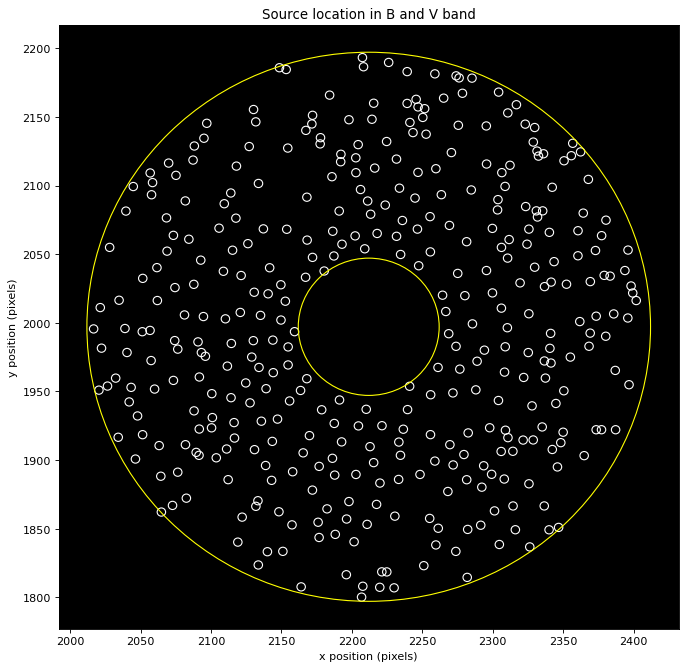

In [40]:
#This image shows all the sources after the SNR of 3 restriction has been applied 

xB = tableB2['starsBx2']
yB = tableB2['starsBy2']
xV = tableV2['starsVx2']
yV = tableV2['starsVy2']

fig = plt.figure(figsize=(10, 10), dpi=80)
ax1 = fig.add_subplot(1, 1, 1)

ax1.set_facecolor('black')
ax1.scatter(xB, yB, marker = 6, alpha=1, color='black', linewidths=1)
#ax1.scatter(xV, yV, marker = 7, alpha=1, color='red', linewidths=1)
for i in range(len(xB)):
    circles = patches.Circle((xB[i], yB[i]), radius=3, fill=False, edgecolor='white', linewidth=1)
    ax1.add_patch(circles)
    
annulus1 = patches.Circle((xcent, ycent), radius = rmax, fill=False, edgecolor='yellow', linewidth=1)
annulus2 = patches.Circle((xcent, ycent), radius = rmin, fill=False, edgecolor='yellow', linewidth=1)    
ax1.add_patch(annulus1)
ax1.add_patch(annulus2)

#plt.imshow(B-bkgB.background, vmin=0, vmax=200, cmap='inferno')
#plt.xlim(1700,2500)
#plt.ylim(1700,2400)
plt.xlabel('x position (pixels)')
plt.ylabel('y position (pixels)')
plt.title('Source location in B and V band')
plt.savefig('Source location in B and V band')

plt.show()

In [29]:
#Our goal is to now calculate the value of absolute magnitude for each source
#We star off by calculating the apparent magnitude using the instrumental in both the B and V band

magV = -2.5*np.log10(starsV2)
print(magV)
print(len(magV))

[ -8.581131    -9.11194841  -9.19031299  -9.45781728  -8.25407952
  -8.82190073  -8.36099045  -9.35474423  -8.59038701  -8.80202689
  -8.63977806  -9.80626321  -8.88070893  -8.4160813   -8.68502713
  -8.92784274  -8.15429095  -8.78542743  -9.04127015  -8.60267227
  -8.33799021  -8.82046445  -8.67342819  -8.99515232  -8.4787022
  -8.69684624  -8.68376167  -8.40613016  -8.53343668  -8.2159807
  -8.91994093  -9.01592181  -8.78770956  -8.53098308  -8.548534
  -8.57694179  -8.16316557  -9.0557601   -8.83220619  -9.03342792
  -8.71424597  -8.69064073  -8.86852151  -8.93950307  -8.8735552
  -9.28940919  -8.71915793  -8.72102931  -8.41578637  -8.58015057
  -9.99617687  -8.84016095  -8.4951851   -8.55768963  -9.07526385
  -8.37569807  -8.97900091  -8.74581962  -8.82119917  -8.89038877
  -9.88979633  -9.33766674  -8.74845705  -8.68876917  -8.55713606
  -8.78840459  -8.44456411  -8.83015329  -8.8595245   -8.3211137
  -8.83635994  -9.12458851  -9.37877793  -9.0766588   -8.93167685
  -8.91378417  -

In [30]:
magB = -2.5*np.log10(starsB2)
print(magB)
print(len(magB))

[ -7.91270257  -8.0494113   -8.4375241   -8.18819324  -7.49391695
  -7.62062536  -7.60601362  -7.94940394  -7.81206213  -7.84393068
  -7.71394682  -8.84779172  -7.8636692   -7.45543271  -7.68740647
  -7.79573507  -7.27176104  -7.48189924  -7.99307337  -7.72651577
  -7.32876547  -7.79859419  -7.70316581  -7.81599095  -7.65072664
  -7.6690961   -7.76230648  -7.4662247   -7.44861527  -7.13451795
  -7.74027276  -7.98472449  -7.81766373  -7.53581092  -7.53739323
  -7.51855439  -7.41752908  -8.2352521   -7.9132469   -8.08027601
  -7.74441145  -7.70432546  -7.80407848  -8.10049093  -7.8215608
  -8.31237587  -7.68536679  -7.74721169  -7.31169359  -7.5092082
  -8.79438729  -7.78268053  -7.69875885  -7.57628889  -8.46076944
  -7.65969722  -8.03760352  -7.56691887  -7.96101547  -7.89385682
  -8.73069884  -8.58037729  -7.80862998  -7.77247691  -7.61812664
  -7.70279246  -7.5651778   -7.68222612  -8.07771724  -7.64409168
  -7.88755265  -7.94047772  -8.37937805  -8.12021318  -7.90753467
  -8.0479135

In [31]:
#We must calcualte the errors too as this is essential in the CMD fitting

#mag_err = 1.09*starsSS / starserr
mag_errB = []
for i in range(len(starsB2)):
    a = np.sqrt(((-5/(2*np.log(10)*(starsB2[i])))**2)*starsBerr2[i]**2)
    mag_errB.append(a)
print(mag_errB)


[0.09454311093672489, 0.08346086320749009, 0.058515542608083615, 0.07339324081175765, 0.13825890389435325, 0.12353675122009138, 0.12554812313120264, 0.09132532174887788, 0.10424786396294834, 0.10148558316221704, 0.11421401954884881, 0.04096873829177492, 0.09898443827253371, 0.14309355980593733, 0.11611248233088367, 0.10540506112023787, 0.16842950838677648, 0.13888078752270228, 0.08810509815066499, 0.11218509976371585, 0.16140639541329269, 0.105015630496731, 0.11439018287872565, 0.1027092433993586, 0.12021730503199071, 0.11875505436625698, 0.10874188262404813, 0.1410095529053583, 0.14318600515924948, 0.19020243061225306, 0.11149381425196195, 0.08906215052514159, 0.10398355887542746, 0.13289812916694985, 0.1337883276354484, 0.13487175304750856, 0.1475995912062845, 0.07097867231142473, 0.09539540228155233, 0.08203810880183186, 0.1107791681920758, 0.1147802864444056, 0.1049331092616639, 0.07936519062996795, 0.10254871657613042, 0.06584531440399162, 0.11705189981722196, 0.10972813419965091,

In [32]:
#mag_err = 1.09*starsSS / starserr
mag_errV = []
for i in range(len(starsV2)):
    a = np.sqrt(((-5/(2*np.log(10)*(starsV2[i])))**2)*starsVerr2[i]**2)
    mag_errV.append(a)
print(mag_errV)

[0.05878093102243295, 0.036692812608485254, 0.03397705472346965, 0.02703614420774988, 0.07912206362265867, 0.04778302220323632, 0.0724076828883356, 0.029739115340392037, 0.05913696825200436, 0.04914805203307235, 0.05688344915623227, 0.020159187207939185, 0.04539929310793307, 0.06860211350369537, 0.054056877586957965, 0.04365653325221397, 0.08614419903874938, 0.048704839878697906, 0.03936262523691224, 0.058250698199133755, 0.07437048010960902, 0.04782397043003578, 0.05441328738180198, 0.0406409139705308, 0.06510133553450116, 0.05420957130805782, 0.054244590615164796, 0.06830188727435904, 0.060867818436747316, 0.08073045330478831, 0.044569424870514816, 0.04051042284061641, 0.05021169579663546, 0.061963023970199954, 0.061984536617238184, 0.05942062337472155, 0.0860600112048379, 0.03859721619354102, 0.04856158677141362, 0.040597755733910716, 0.05359518248311515, 0.05362547663277465, 0.04670674616804296, 0.042739834282627495, 0.045787382741143294, 0.031129047261378683, 0.053633727934342505,

In [33]:
mag_errB = mag_errB
list_of_abserrB = []
for i in mag_errB:
    absB = abs(i)
    list_of_abserrB.append(absB)
#print(list_of_abserrB)

mag_errV = mag_errV
list_of_abserrV = []
for j in mag_errV:
    absV = abs(j)
    list_of_abserrV.append(absV)
#print(list_of_abserrV)

In [34]:
#Here we specfically pick out a reference star within our table to calculate the zeropoint in order to normalise our data

maskV = aperture_tableV['id'] == 77
fluxV = aperture_tableV[maskV]['aperture_sum']
print(fluxV)
print(aperture_tableV[maskV]['xcenter'], aperture_tableV[maskV]['ycenter'])
maskB = aperture_tableB['id'] == 77
fluxB = aperture_tableB[maskB]['aperture_sum']
print(fluxB)

   aperture_sum  
-----------------
4213753.301310964
[549.14413924] pix [425.1480206] pix
   aperture_sum   
------------------
1818694.9605129731


   aperture_sum   
------------------
-15.64939965849548
   aperture_sum   
------------------
24.249399658495477
   aperture_sum   
------------------
-16.56167276445477
   aperture_sum  
-----------------
23.88167276445477


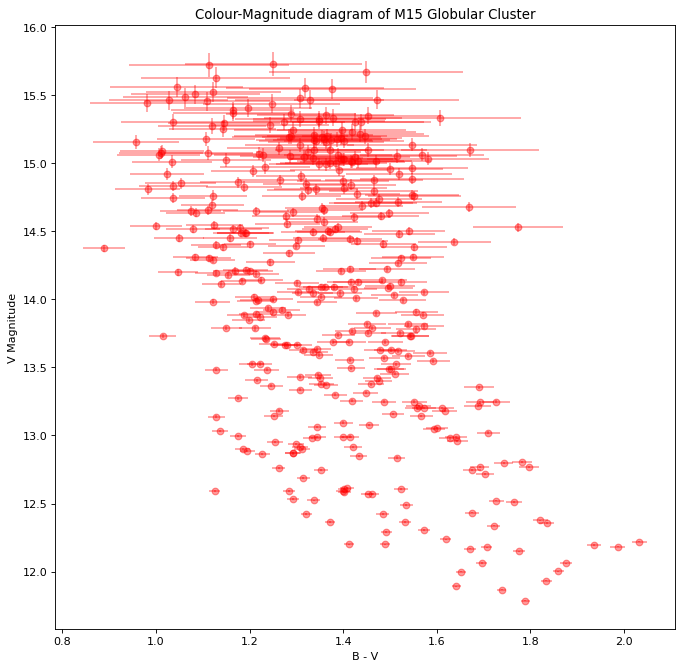

In [35]:
#We have calculated the zeropoint for both the B and V band and have calculated the absolute magntiude
#We then have to calculate the errors on the absolute magnitude on V (which will be our y axis)
#And we have to caulcaute the error on the absoltue mag of (B-V) which will be our x axis
#We then plot our CMD

magSB = -2.5*np.log10(fluxB)
print(magSB)
zeropointB = 8.6-magSB
print(zeropointB)

magB = -2.5*np.log10(np.array(starsB2))
#print(magB)
mag_errB = 1.09*np.array(starsBerr2) / np.array(starsB2)
#print(mag_errB)
#divide the flux in the sum by the flux of Vega in the same band (flux(Vega) = 6.2*10**-9 in B band)
magBcalibrated = -2.5*np.log10(np.array(starsB2)) + zeropointB
#print(magBcalibrated)
#error doesn't need further calibration because we're only removing a constant with no error

magSV = -2.5*np.log10(fluxV)
print(magSV)
zeropointV=7.32-magSV
print(zeropointV)

magV = -2.5*np.log10(np.array(starsV2))
#print(magV)
mag_errV = 1.09*np.array(starsVerr2) / np.array(starsV2)
#print(mag_errV)
#divide the flux in the sum by the flux of Vega in the same band (flux(Vega) = 3.55*10**-9 in B band)
magVcalibrated = -2.5*np.log10((np.array(starsV2))) + zeropointV
#print(magVcalibrated)

BminusV = magBcalibrated - magVcalibrated
BminusVerr = (np.array(list_of_abserrB)**2 + np.array(list_of_abserrV)**2)**0.5
#print(BminusV)
#print(BminusVerr)

x = BminusV
y = magVcalibrated

plt.figure(figsize=(10, 10), dpi=80)
plt.errorbar(x, y ,xerr = BminusVerr, yerr = mag_errV ,fmt ='o', c='r', alpha = 0.4)
#plt.scatter(x, y, marker = 'x', alpha=0.6)

#plt.xlim(-5, 5)
#plt.ylim(22, 12)
plt.xlabel('B - V')
plt.ylabel('V Magnitude')
plt.title('Colour-Magnitude diagram of M15 Globular Cluster')
plt.savefig('Colour-Magnitude diagram of M15 Globular Cluster')

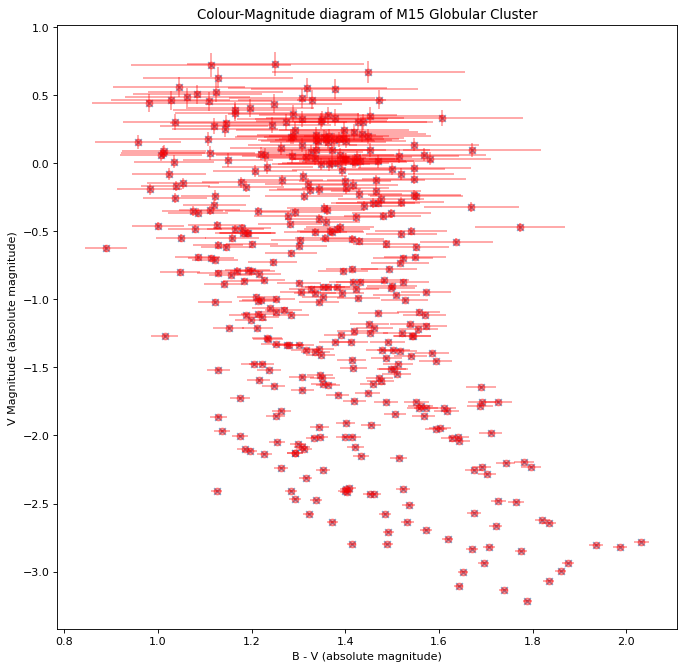

In [36]:
#Our CMD here will take the distance to the cluster into account 

D = 10000

absmagB = magBcalibrated - 5*np.log10(D/10)
absmagV = magVcalibrated - 5*np.log10(D/10)

absBminusV = absmagB - absmagV
absBminusVerr = (np.array(list_of_abserrB)**2 + np.array(list_of_abserrV)**2)**0.5
#print(absBminusV)
#print(absBminusVerr)

x = absBminusV
y = absmagV
#print(x)
#print(y)

plt.figure(figsize=(10, 10), dpi=80)
plt.errorbar(x, y ,xerr = absBminusVerr, yerr = mag_errV ,fmt ='o', c='r', alpha = 0.4)
plt.scatter(x, y, marker = 'x', alpha=0.6)

#plt.xlim(-5, 5)
#plt.ylim(5,-5)
plt.xlabel('B - V (absolute magnitude)')
plt.ylabel('V Magnitude (absolute magnitude)')
plt.title('Colour-Magnitude diagram of M15 Globular Cluster')
plt.savefig('Colour-Magnitude diagram of M15 Globular Cluster')

In [38]:
#ISOCHRONE FITS
#We now generate isochrone fits from a table we found(look at report)

isochrone = np.genfromtxt(fname = r'C:/Users/steve/OneDrive - University of Birmingham/LH Observatory Laboratory/Glob Cluter Final Code/GlobClusters/Isochrones1.dat', comments = '#', delimiter=None, usecols = (0, 1, 2, 29, 30))
print(isochrone)

#209

[[ 6.634300e-05 -2.191740e+00  1.000000e+01  1.445100e+01  1.289000e+01]
 [ 6.634300e-05 -2.191740e+00  1.000000e+01  1.381100e+01  1.238300e+01]
 [ 6.634300e-05 -2.191740e+00  1.000000e+01  1.286000e+01  1.160200e+01]
 ...
 [ 6.634300e-05 -2.191740e+00  1.014613e+01 -1.120000e+00 -2.591000e+00]
 [ 6.634300e-05 -2.191740e+00  1.014613e+01 -1.120000e+00 -2.620000e+00]
 [ 6.634300e-05 -2.191740e+00  1.014613e+01  3.007300e+01  3.011500e+01]]


C:\Users\steve\AppData\Local\Temp/ipykernel_10856/3059520770.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x, y ,xerr = absBminusVerr, yerr = mag_errV ,fmt ='o', marker = 'x', c='grey', alpha=0.5)


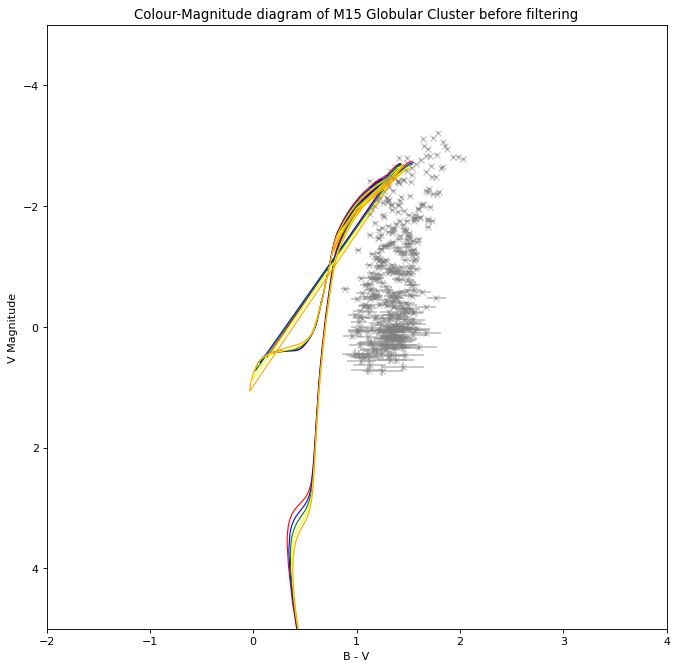

In [39]:
#This is our final plot including our isochrone with our CMD

x = absBminusV
y = absmagV
#print(x)
#print(y)

plt.figure(figsize=(10, 10), dpi=80)
plt.errorbar(x, y ,xerr = absBminusVerr, yerr = mag_errV ,fmt ='o', marker = 'x', c='grey', alpha=0.5)
#plt.scatter(x, y, marker = 'x', alpha=0.2)

#plt.xlim(-5, 5)
#plt.ylim(22, 12)
plt.xlabel('B - V (absolute magnitude)')
plt.ylabel('V Magnitude (absolute magnitude)')
plt.title('Colour-Magnitude diagram of M15 Globular Cluster before filtering')
plt.savefig('Colour-Magnitude diagram of M15 Globular Cluster before filtering')

isochrone = isochrone[isochrone[:,0] == 6.6343e-05]
isochrone1 = isochrone[isochrone[:,2] == 10.0][:-1, :]
isochrone2 = isochrone[isochrone[:,2] == 10.04139][:-1, :]
isochrone3 = isochrone[isochrone[:,2] == 10.07918][:-1, :]
isochrone4 = isochrone[isochrone[:,2] == 10.11394][:-1, :]
isochrone5 = isochrone[isochrone[:,2] == 10.14613][:-1, :]

x1 = isochrone1[:, 4]
y1 = isochrone1[:, 3] - isochrone1[:, 4]

#print(x1)
#print(y1)

plt.plot(y1, x1, c='red', linewidth='1')

x2 = isochrone2[:, 4]
y2 = isochrone2[:, 3] - isochrone2[:, 4]

#print(x2)
#print(y2)

plt.plot(y2, x2, c='blue', linewidth='1')

x3 = isochrone3[:, 4]
y3 = isochrone3[:, 3] - isochrone3[:, 4]

#print(x2)
#print(y2)

plt.plot(y3, x3, c='green', linewidth='1')

x4 = isochrone4[:, 4]
y4 = isochrone4[:, 3] - isochrone4[:, 4]

#print(x2)
#print(y2)

plt.plot(y4, x4, c='yellow', linewidth='1')

x5 = isochrone5[:, 4]
y5 = isochrone5[:, 3] - isochrone5[:, 4]

#print(x2)
#print(y2)

plt.plot(y5, x5, c='orange', linewidth='1')

plt.xlim(-2, 4)
plt.ylim(5, -5)
plt.xlabel('B - V')
plt.ylabel('V Magnitude')
plt.title('Colour-Magnitude diagram of M15 Globular Cluster before filtering')
plt.savefig('Colour-Magnitude diagram of M15 Globular Cluster before filtering')